In [ ]:
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [45]:
image_path = r"/home/ahad/Desktop/research/PointCloud-Diffusion/data/img"
lidar_path = r"/home/ahad/Desktop/research/PointCloud-Diffusion/data/velo"

image_files = sorted(glob.glob(f"{image_path}/*.png"))  
lidar_files = sorted(glob.glob(f"{lidar_path}/*.bin"))

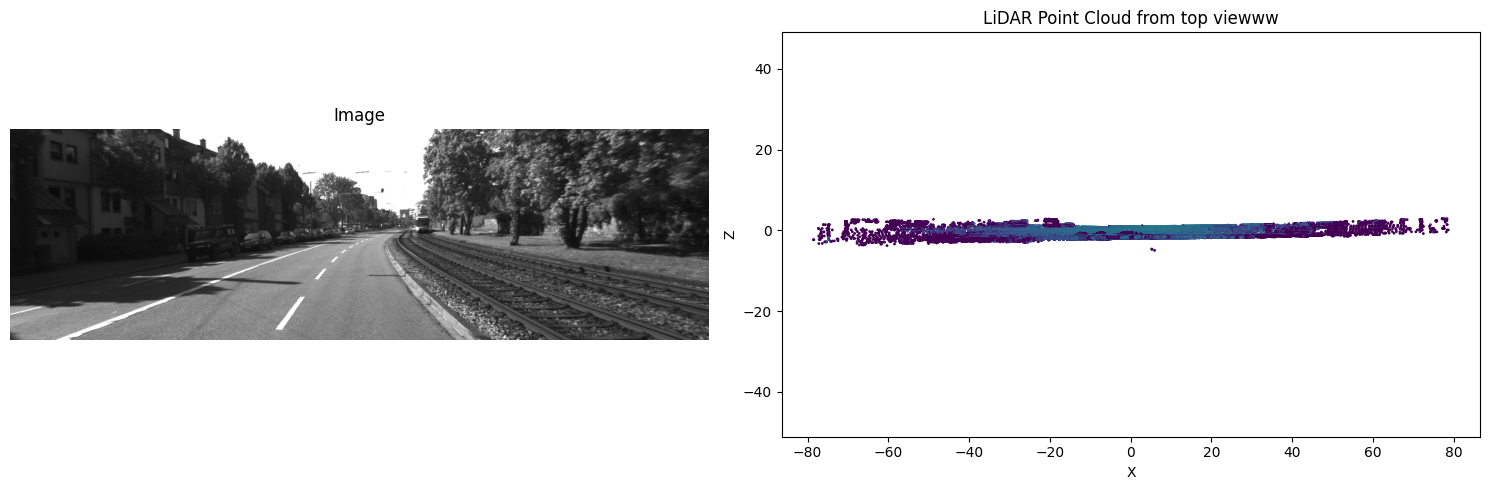

In [46]:

if len(image_files) != len(lidar_files):
    print("check yur # of filezzz")
else:

    image_file = image_files[0]
    lidar_file = lidar_files[0]

    image = Image.open(image_file)
    if image.mode != 'RGB':
        image = image.convert('RGB')


    lidar_data = np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)  
    x, y, z, intensity = lidar_data.T  

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title("Image")

 
    axes[1].scatter(x, z, c=intensity, s=1, cmap='viridis')
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Z')
    axes[1].set_title("LiDAR Point Cloud from top viewww")
    axes[1].axis('equal')  

    plt.tight_layout()
    plt.show()


In [47]:

# calibratiom matrices from the file in repo
R = np.array([[7.533745e-03, -9.999714e-01, -6.166020e-04],
              [1.480249e-02, 7.280733e-04, -9.998902e-01],
              [9.998621e-01, 7.523790e-03, 1.480755e-02]])

T = np.array([-4.069766e-03, -7.631618e-02, -2.717806e-01])


P = np.array([[7.215377e+02, 0, 6.095593e+02, 0],
              [0, 7.215377e+02, 1.728540e+02, 0],
              [0, 0, 1, 0]])


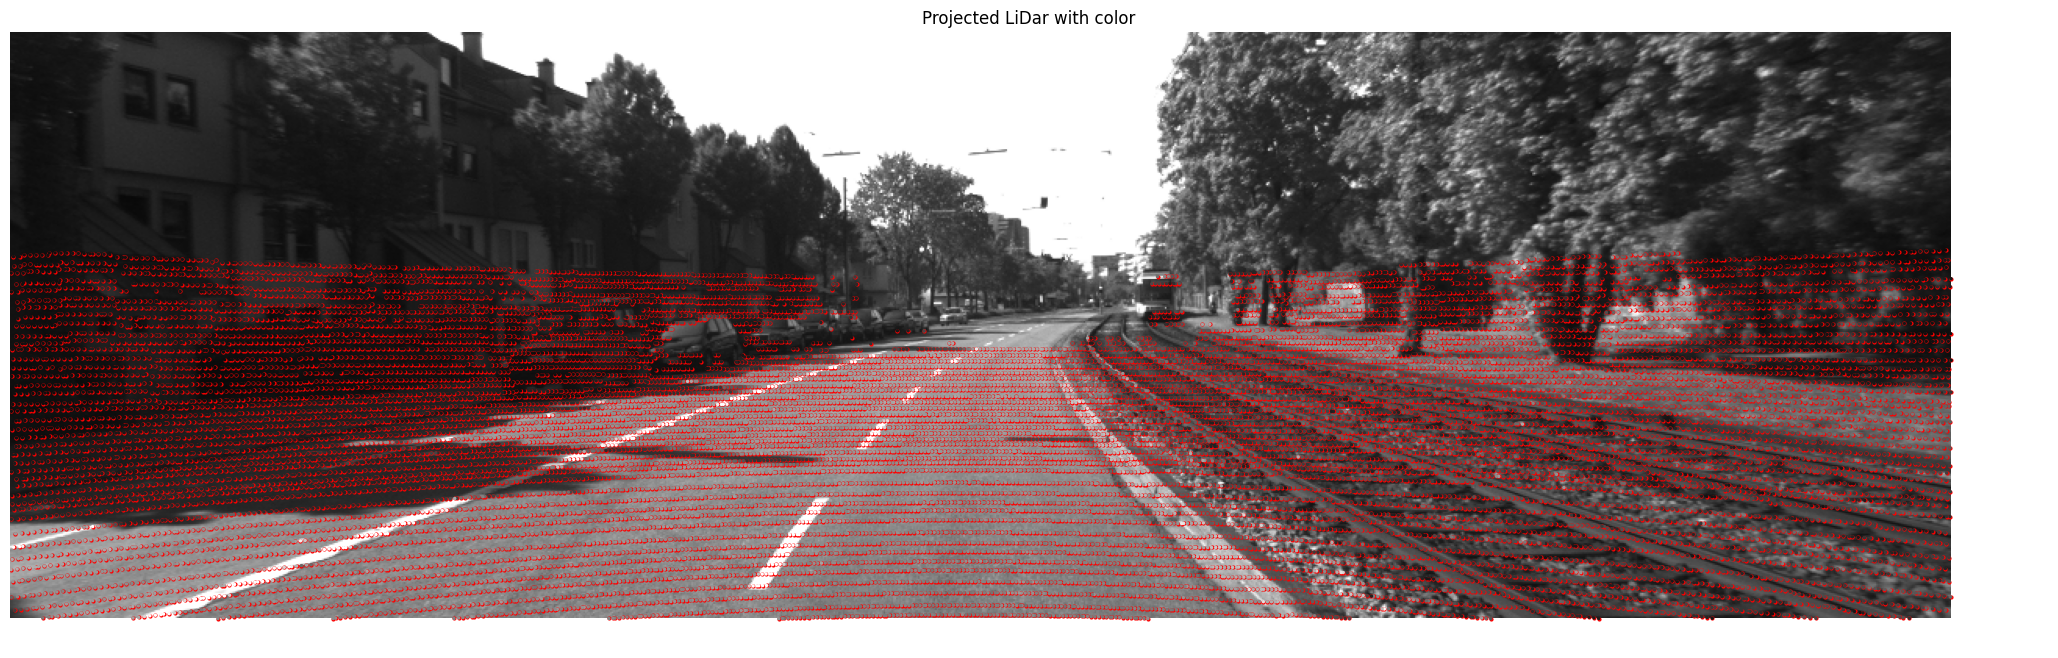

In [61]:

num = 0

if len(image_files) != len(lidar_files):
    print("check ur num of files")
else:

    image_file = image_files[num]
    lidar_file = lidar_files[num]

    image = Image.open(image_file)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    img_width, img_height = image.size

    image_array = np.array(image)

    
    lidar_data = np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)  # [x, y, z, intensity]

    
    lidar_points = lidar_data[:, :3]
    lidar_points_homogeneous = np.hstack((lidar_points, np.ones((lidar_points.shape[0], 1))))  
    transformed_points = lidar_points @ R.T + T


    points_3d_cam = np.hstack((transformed_points, np.ones((transformed_points.shape[0], 1))))  
    points_2d_homogeneous = points_3d_cam @ P.T

    
    points_2d = points_2d_homogeneous[:, :2] / points_2d_homogeneous[:, 2, None]

    valid_indices = (points_2d_homogeneous[:, 2] > 0) & \
                    (points_2d[:, 0] >= 0) & (points_2d[:, 0] < img_width) & \
                    (points_2d[:, 1] >= 0) & (points_2d[:, 1] < img_height)

    points_2d = points_2d[valid_indices]
    lidar_intensity = lidar_data[valid_indices, 3]  

    points_2d_int = points_2d.astype(int)
    colors = image_array[points_2d_int[:, 1], points_2d_int[:, 0], :] 


    plt.figure(figsize=(50, 8))
    plt.imshow(image)

    # use for outline so u can see color better
    plt.scatter(points_2d[:, 0], points_2d[:, 1], c="red", s=4)
    plt.scatter(points_2d[:, 0], points_2d[:, 1], c=colors / 255.0, s=2)
    plt.axis('off')
    plt.title("Projected LiDar with color")
    plt.show()


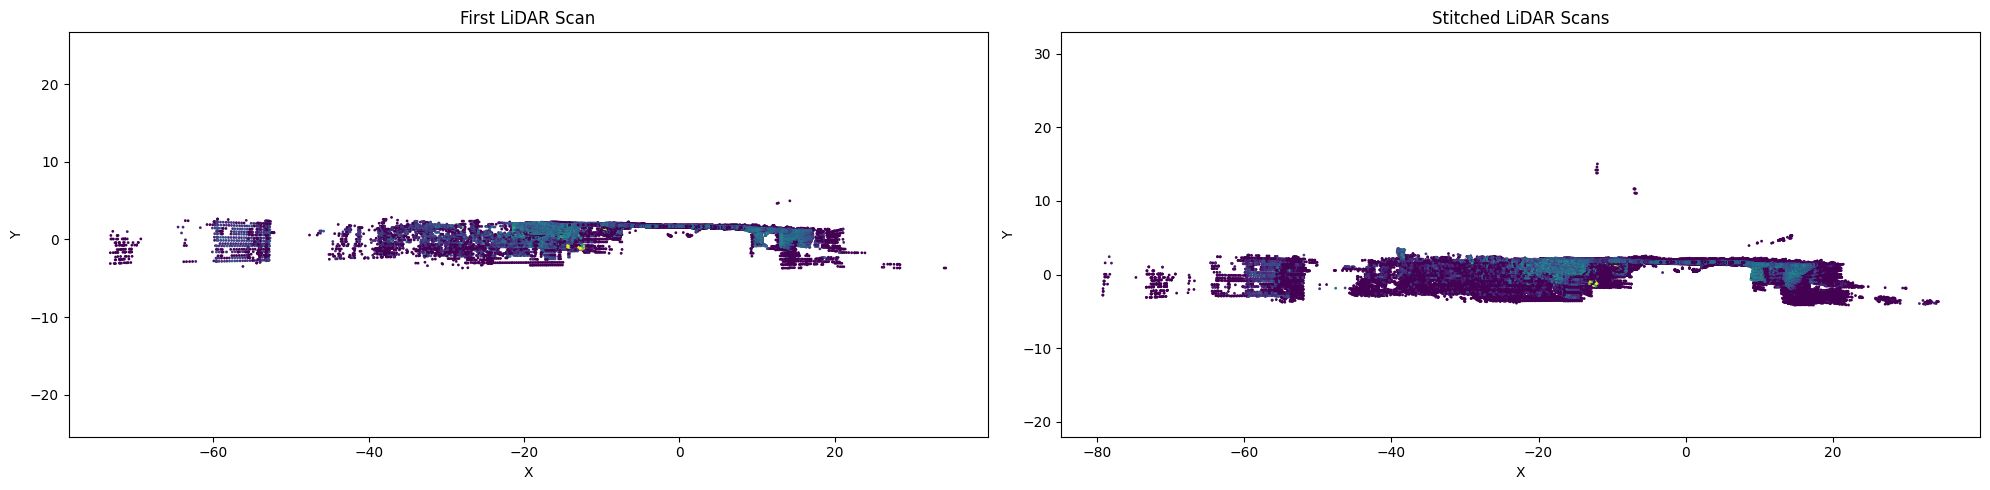

In [49]:
all_lidar_points = []

first_lidar_file = lidar_files[0]
first_lidar_data = np.fromfile(first_lidar_file, dtype=np.float32).reshape(-1, 4)
first_lidar_points = first_lidar_data[:, :3]
first_lidar_intensity = first_lidar_data[:, 3]

first_transformed_points = first_lidar_points @ R.T + T

all_lidar_points.append(np.hstack((first_transformed_points, first_lidar_intensity[:, None])))

for lidar_file in lidar_files:
    lidar_data = np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)
    lidar_points = lidar_data[:, :3]
    lidar_intensity = lidar_data[:, 3]

    transformed_points = lidar_points @ R.T + T

    all_lidar_points.append(np.hstack((transformed_points, lidar_intensity[:, None])))

stitched_lidar_points = np.vstack(all_lidar_points)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].scatter(first_transformed_points[:, 0], first_transformed_points[:, 1], c=first_lidar_intensity, s=1, cmap='viridis')
axes[0].set_title("First LiDAR Scan")
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")
axes[0].axis('equal')

axes[1].scatter(stitched_lidar_points[:, 0], stitched_lidar_points[:, 1], c=stitched_lidar_points[:, 3], s=1, cmap='viridis')
axes[1].set_title("Stitched LiDAR Scans")
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y")
axes[1].axis('equal')

plt.tight_layout()
plt.show()


In [ ]:
points_2d_int = points_2d.astype(int)
image_array = np.array(image)

fig = go.Figure()
fig.add_trace(
    go.Image(z=np.array(image))
)
fig.add_trace(
    go.Scatter(x=points_2d[:, 0], y=points_2d[:, 1],
               mode='markers',
               marker=dict(color=colors/255.0, size=3),
               name='LiDAR Points')
)
fig.update_layout(
    title="Lidar with the extracted colors from pic",
    xaxis=dict(title="X-axis", showgrid=False, zeroline=False),
    yaxis=dict(title="Y-axis", showgrid=False, zeroline=False, scaleanchor="x", scaleratio=1),
    height=800,
)
fig.show()
